In [1]:
import numpy as np
from scipy.spatial.distance import cdist, pdist

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
D = 10000
numGestures = 13
numPositions = 8

In [3]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

In [4]:
n = np.round(np.logspace(1,np.log10(5000),100)).astype('int')
x = np.round(np.logspace(-0.5,np.log10(5000),20)).astype('int')
# x = np.round(np.linspace(0,5000,20)).astype('int')
numIter = 1

dOut = np.zeros((len(n),numIter))
cOut = np.zeros((len(x),numIter))
mOut = np.zeros((len(n),len(x),numIter))

for ii in tqdm(range(numIter)):
    for i,NFlipA in enumerate(n):
        
        allCentroids = np.zeros((numGestures,numPositions,D))

        seed = np.random.choice([-1.0, 1.0], size=D)
        for g in range(numGestures):
            for p in range(numPositions):
                flipIdx = np.random.permutation(D)[:NFlipA]
                flipBits = np.ones(D)
                flipBits[flipIdx] = -1
                allCentroids[g,p,:] = seed*flipBits

        temp = allCentroids.reshape(-1,D)
        d = cdist(temp,temp,'hamming')
        dOut[i,ii] = np.mean(d[~np.eye(d.shape[0],dtype=bool)])
        
        for j,NFlipB in enumerate(x):            

            contexts = np.zeros((numPositions,D))
            seed = np.random.choice([-1.0, 1.0], size=D)
            for p in range(numPositions):
                flipIdx = np.random.permutation(D)[:NFlipB]
                flipBits = np.ones(D)
                flipBits[flipIdx] = -1
                contexts[p,:] = seed*flipBits
            if i == 0:    
                temp = contexts.reshape(-1,D)
                d = cdist(temp,temp,'hamming')
                cOut[j,ii] = np.mean(d[~np.eye(d.shape[0],dtype=bool)])

            for g in range(numGestures):
                for p in range(numPositions):
                    allCentroids[g,p,:] *= contexts[p,:]

            prototypes = np.zeros((numGestures,D))
            for g in range(numGestures):
                prototypes[g,:] = bipolarize(np.sum(allCentroids[g,:,:],axis=0))

            margins = np.zeros((numGestures,numPositions))
            for g in range(numGestures):
                for p in range(numPositions):
                    
                    dists = cdist(allCentroids[g,p,:].reshape(1,-1),prototypes,'hamming')[0]
                    b = np.min(np.delete(dists,g))
                    a = dists[g]
                    margins[g,p] = (b - a)/(b + a)

            mOut[i,j,ii] = np.mean(margins)

100%|██████████| 20/20 [32:22<00:00, 97.10s/it]


Text(0, 0.5, 'Classifier margin')

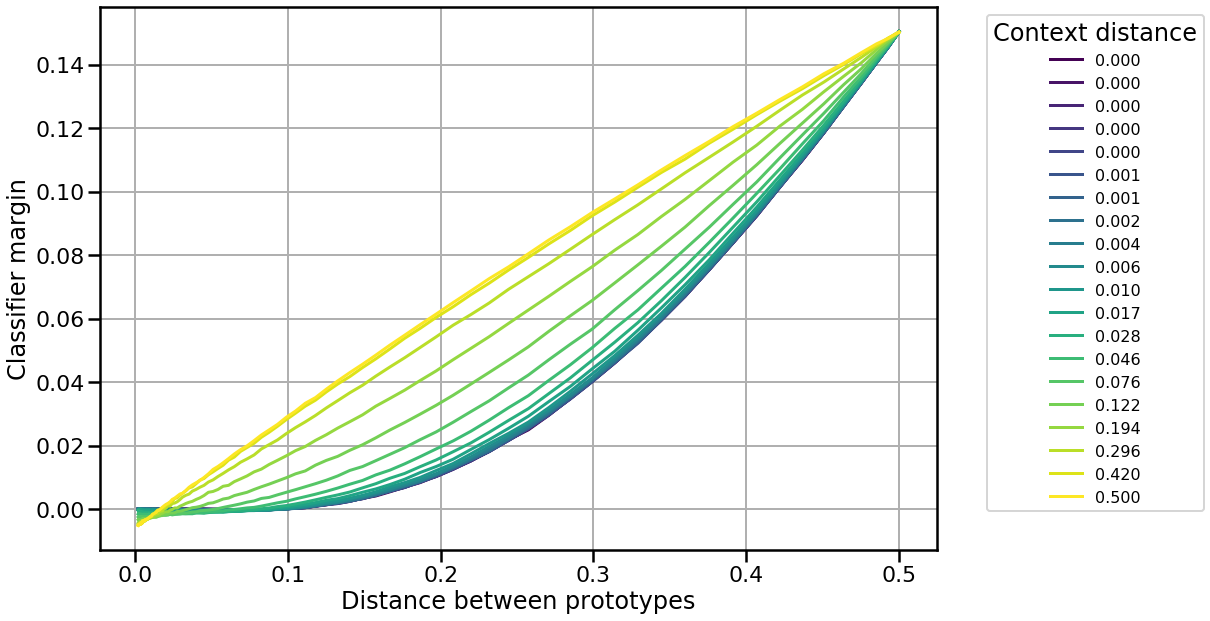

In [5]:
sns.set_context('poster')
# colors = plt.cm.plasma(np.linspace(0,1,len(x)))
# colors = plt.cm.jet(np.linspace(0,1,len(x)))
colors = plt.cm.viridis(np.linspace(0,1,len(x)))
f,ax = plt.subplots(figsize=(15,10))
for i in range(len(x)):
    ax.plot(np.mean(dOut,axis=1),np.mean(mOut,axis=2)[:,i],color=colors[i])
ax.grid(True)
ax.legend(['%.3f' % c for c in np.mean(cOut,axis=1)],bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title='Context distance')
ax.set_xlabel('Distance between prototypes')
ax.set_ylabel('Classifier margin')